% ```{code-cell}
% mpl.rcParams['axes.spines.top'] = 0
% mpl.rcParams['axes.spines.right'] = 0
% mpl.rcParams['axes.spines.left'] = 1
% mpl.rcParams['axes.spines.bottom'] = 1
% mpl.rcParams.update({'font.size': 12})
% ```
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(ch:edge-detection)=
# Filtering and Boundary Detection (Mark Starzynski)
written by Mark Starzynski

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#from tqdm import tqdm

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## Introduction
This chapter will introduce what filters are and how they are used in image processing for boundary detection. Boundary or edge detection (which are not the same) are very important as early processing tools for pattern recognition tasks in images for example, where we would like to automatically recognize patterns and regularities in data in order to ascertain what object those pixel values are representing. 

![image.png](images/05-filtering-and-edge-detection/canny.png)
Example of Canny Detection. JonMcLoone (TODO: proper credit)

This is easier said than done, because a lot of issues arise when trying to automatically identify objects on images. Poor contrast, shadows and difficult textures can make detecting objects in an image quite difficult.

![image.png](images/05-filtering-and-edge-detection/be-challenge.png)
Credit: Alex Schwing; image credits tbd (TODO: proper credit)

 While humans - a lifetime well-trained in pattern recognition - can confidently deal with those issues in most cases, visual perception in computer vision is a little trickier. Regardless one can hopefully see how successfully extracting the most relevant boundaries is a good first step in order to detect what object is displayed on an image. 

```{admonition} Question: Do you know the difference between edge and boundary detection?
:class: hint, dropdown
Boundary detection is distinct from edge detection in the sense that it deals with finding the semantic boundaries between what humans would consider to be different objects or regions of the image, meaning in the example images we can distinguish ...

- ... boundaries between the black vest of the person and the black background.
- ... shadows on the rhinoceros and neglect them in regards to boundaries of the rhinoceros itself.
- ... the zebra from the background even though the texture of both is very alike. 

So whereas boundary detection identifies within a contextual basis as well, edge detection only deals with the boundaries between light and dark pixels. In the following we will focus on the latter.
```

## Edge Detection: An example
Edge detection finds edges by looking at the difference of neighbouring pixel values. An edge is defined by its contrast (the difference in intensity between pixel values), and - in general - also by other low-level image characteristics such as brightness in color and color changes. For our purposes we will focus on a gray image and try to detect the edges by its gradient. {cite}`CVAA`

```{admonition} Recap: Gradient 
:class: note, dropdown
The gradient of an image can be denoted as 

$$
\nabla I(x) = \bigl( \frac{\partial I}{\partial x} , \frac{\partial I}{\partial y}  \bigr)(x)
$$

This calculated vector points in the perpendicular direction of the local edge countour. We can zoom in on the previous zebra pictures to see how this is the case.

![image.png](images/05-filtering-and-edge-detection/gradient.png)

The direction of the gradient can be calculated with 

$$
\varTheta = tan^{-1} \bigl( \frac{\partial I}{\partial x} / \frac{\partial I}{\partial y} \bigr)
$$

The stronger the change in intensity, the bigger the magnitude of the vector. We can denote the magnitude as

$$
\| \nabla I(x) \| = \sqrt{(\frac{\partial I}{\partial x})^2 + (\frac{\partial I}{\partial y})^2} 
$$

This in itself is very benefitial to calculate "edge strength" on a local level. 
```
Lets look at an example.

In [2]:
'''
Code on the basis of the lecture from October 25th 2022
'''
from scipy.io import loadmat
from skimage import color
from skimage import io

img = io.imread('images/05-filtering-and-edge-detection/basel.jpg')
img_bw = color.rgb2gray(img)

img_dx = np.diff(img_bw, axis=0, prepend=0)
img_dy = np.diff(img_bw, axis=1, prepend=0)
gradnorm = np.sqrt(img_dx**2 + img_dy**2)

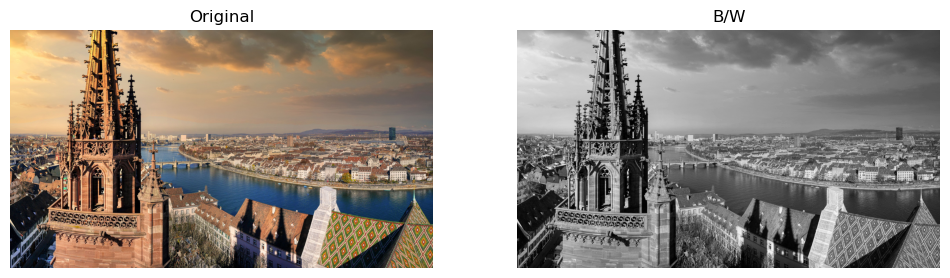

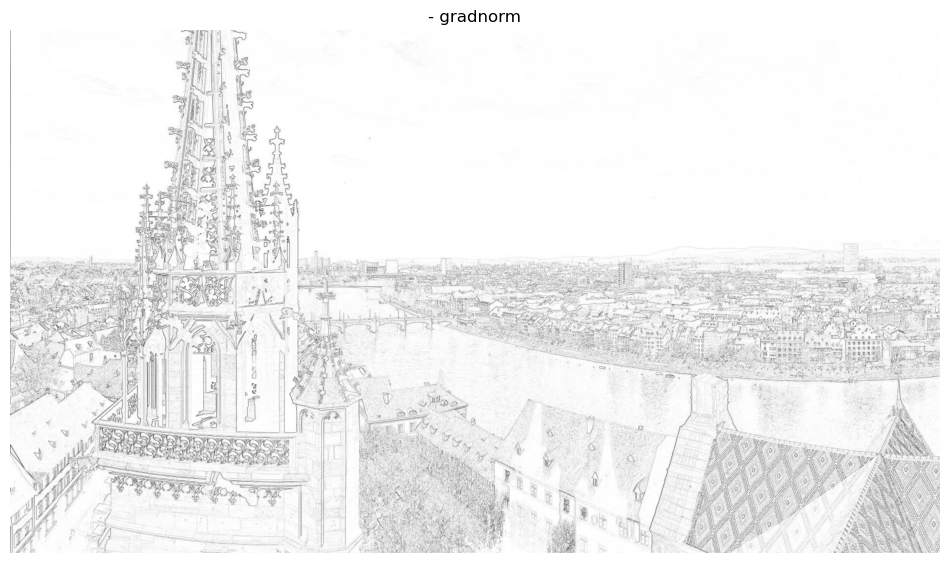

In [3]:
# plotting
_,axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].title.set_text('Original')
axs[0].imshow(img)
axs[0].axis(False)

axs[1].title.set_text('B/W')
axs[1].imshow(img_bw, cmap='gray')
axs[1].axis(False)

_,ax = plt.subplots(1, 1, figsize=(12, 12))
ax.title.set_text('- gradnorm')
ax.imshow(-gradnorm, cmap='gray')
ax.axis(False)
plt.show()

As one can see calculating the "edge strength" can be a nice indicator for detecting edges in this case. But what happens if we add noise to the image?

In [4]:
sig = 0.3
img_bw_n = img_bw + sig*np.random.randn(*img_bw.shape)

img_dx = np.diff(img_bw_n, axis=0, prepend=0)
img_dy = np.diff(img_bw_n, axis=1, prepend=0)
gradnorm2 = np.sqrt(img_dx**2 + img_dy**2)

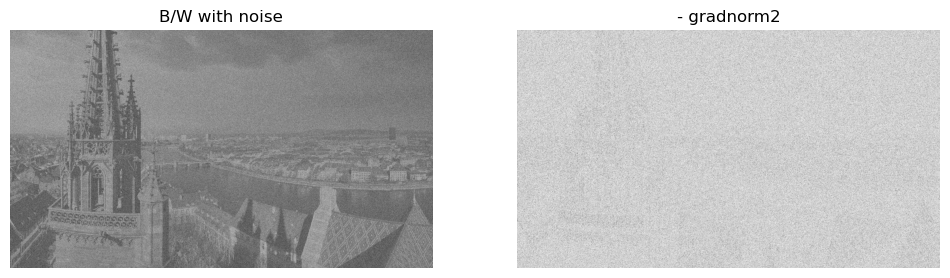

In [5]:
# plotting
_,axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].title.set_text('B/W with noise')
axs[0].imshow(img_bw_n, cmap='gray')
axs[0].axis(False)

axs[1].title.set_text('- gradnorm2')
axs[1].imshow(-gradnorm2, cmap='gray')
axs[1].axis(False)
plt.show()

It seems that we can't quite detect edges well on a noisy image. This is not surprising considering we have added a lot of variation with the noise and since our basic edge detection process naturally accentuates high frequencies it only amplified the noise. What can be done in this case? We want to attenuate the high frequency noise in order to more so passively accentuate the important lower frequencies. So we want to smooth out the image to lessen the noise. This can be done with convolution. For now, let it suffice to say that a convolution applies a smaller convolution matrix to the image in order to for example blur, sharpen, emboss, edge detect and more. This convolution matrix is also called a kernel, filter or mask and in the following we will apply two versions to smooth out/blur the image.

### Kernels
In the following two examples of kernels are shown, which we will apply to the image via convolution.
#### Gaussian Kernel

In [6]:
from scipy.signal import convolve2d

# creates a gaussian kernel
def gaussian_kernel(kernel_length, sigma):
    l = kernel_length
    x = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(x) / np.square(sigma))
    kernel = np.outer(gauss, gauss)

    return kernel / np.sum(kernel)


gauss_kernel = gaussian_kernel(9, 2)
img_filt = convolve2d(img_bw_n, gauss_kernel)
img_dx = np.diff(img_filt, axis=0, prepend=0)
img_dy = np.diff(img_filt, axis=1, prepend=0)
gradnorm3 = np.sqrt(img_dx**2 + img_dy**2)

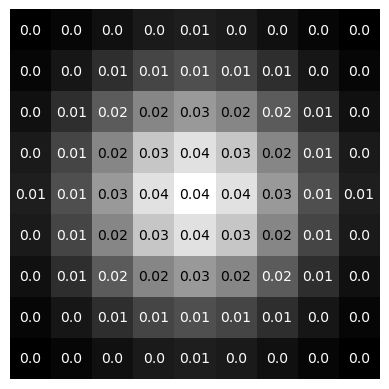

In [7]:
# plotting gaussian kernel
fig, ax = plt.subplots(1, 1)
ax.imshow(gauss_kernel, cmap='gray')
l,_ = gauss_kernel.shape
threshold = np.min(gauss_kernel) + (np.max(gauss_kernel) - np.min(gauss_kernel))/2
for i in range(l):
    for j in range(l):
        if gauss_kernel[i, j] >= threshold:
            txt_color = 'k'
        else: txt_color = 'w'
        text = ax.text(j, i, np.round(gauss_kernel[i, j], decimals=2),
                       ha='center', va='center', color=txt_color)
plt.axis('off')
plt.show()

#### "One-Kernel"

In [8]:
# creates one-kernel
s = 9
one_kernel = np.ones((s, s)) / s**2
img_filt = convolve2d(img_bw_n, one_kernel)
img_dx = np.diff(img_filt, axis=0, prepend=0)
img_dy = np.diff(img_filt, axis=1, prepend=0)
gradnorm4 = np.sqrt(img_dx**2 + img_dy**2)

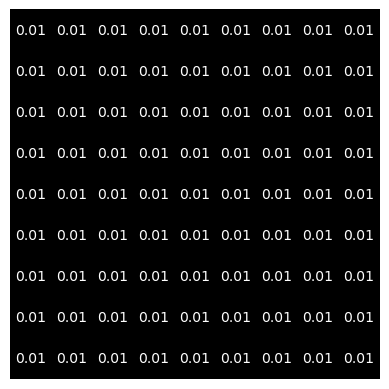

In [9]:
# plotting one-kernel
fig, ax = plt.subplots(1, 1)
ax.imshow(one_kernel, cmap='gray')
l,_ = one_kernel.shape
threshold = np.min(one_kernel) + (np.max(one_kernel) - np.min(one_kernel))/2
for i in range(l):
    for j in range(l):
        text = ax.text(j, i, np.round(one_kernel[i, j], decimals=2),
                       ha='center', va='center', color='w')
plt.axis('off')
plt.show()

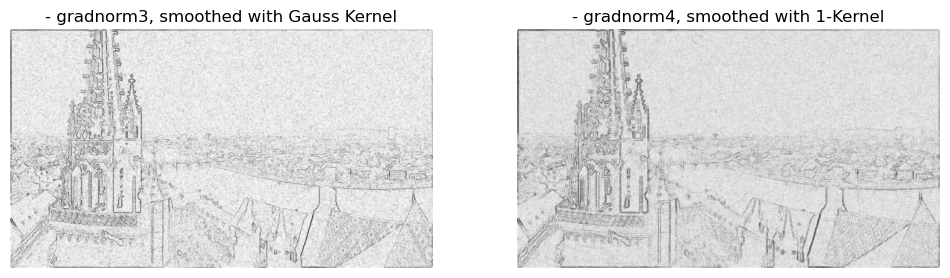

In [10]:
# plotting
_,axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].title.set_text('- gradnorm3, smoothed with Gauss Kernel')
axs[0].imshow(-gradnorm3, cmap='gray')
axs[0].axis(False)

axs[1].title.set_text('- gradnorm4, smoothed with 1-Kernel')
axs[1].imshow(-gradnorm4, cmap='gray')
axs[1].axis(False)
plt.show()

By convolving the image with those kernels we have managed to bring back those edges regardless of the noise. Lets look at a close-up of an edge.

In [11]:
img = color.rgb2gray(io.imread('images/05-filtering-and-edge-detection/edge2.jpg'))
sig = 0.1
img_noise = img + sig*np.random.randn(*img.shape)

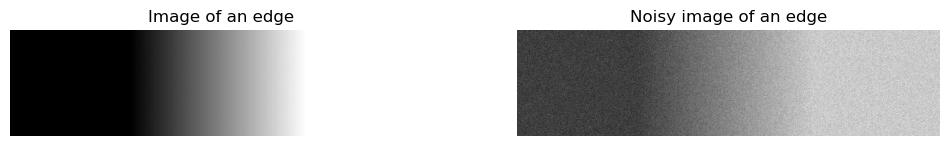

In [12]:
# plotting
_,axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].title.set_text('Image of an edge')
axs[0].imshow(img, cmap='gray')
axs[0].axis(False)

axs[1].title.set_text('Noisy image of an edge')
axs[1].imshow(img_noise, cmap='gray')
axs[1].axis(False)
plt.show()

In order to better understand what happened with applying convolution and maybe further elaborate on how we speak of frequencies in 2D images we can take just one row of this image in order to make it an one-dimensional array $x \in \{ 0,1,...,255\}^{1\times800}$ (any row here contains more or less the same anyway). We plot the original and the derivative (remember how we calculated "edge strength" in 2D with the gradient).

In [13]:
# original image
img = color.rgb2gray(io.imread('images/05-filtering-and-edge-detection/edge2.jpg'))
x1 = np.linspace(0,800,800)
y1 = img[100]

# noisy image
sig = 0.1
img_noise = img + sig*np.random.randn(*img.shape)

x2 = np.linspace(0,800,800)
y2 = img_noise[100]
dy = np.diff(y2)

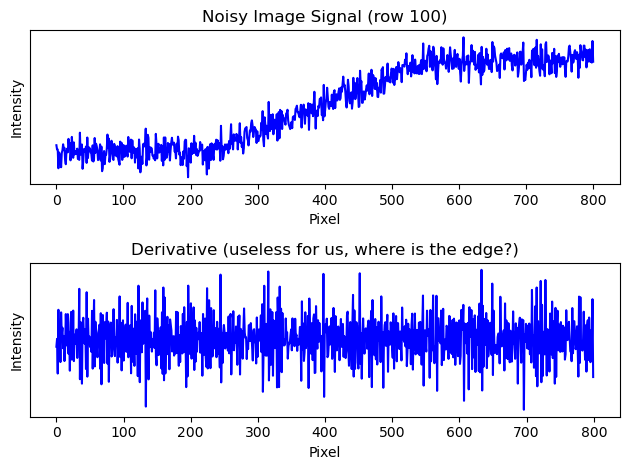

In [14]:
# plotting
fig = plt.figure()

ax = fig.add_subplot(2, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel("Intensity")
ax.set_xlabel("Pixel")
ax.set_yticks([])
ax.set_title('Noisy Image Signal (row 100)')
ax.plot(x2,y2, 'b')

ax = fig.add_subplot(2, 1, 2)
ax.set_title('Derivative (useless for us, where is the edge?)')
ax.set_ylabel("Intensity")
ax.set_xlabel("Pixel")
ax.set_yticks([])
ax.xaxis.set_ticks_position('bottom')
ax.plot(x2[:799], dy, 'b')

fig.tight_layout()
plt.show()

We see that we cant properly derive an edge because the high frequency noise is just too disturbing. What we need to do is smooth out the signal so just the low frequency bands get picked up. We use a kernel to swipe through the image signal and smoothen out the high frequency noise.

In [15]:
# gaussian kernel
def gaussian_kernel(kernel_length, sigma2):
    l = kernel_length
    x = np.linspace(-(l - 1)/2.0, (l - 1)/2.0, l)
    gauss = np.exp(-0.5 * np.square(x) / np.square(sigma2))
    kernel = np.outer(gauss, gauss)

    return kernel / np.sum(kernel)

gauss_kernel = gaussian_kernel(201, 30)

height, width = gauss_kernel.shape
x3 = np.linspace(0, width, width)
y3 = gauss_kernel[height//2]

# smooth signal, convoluted
img_filt = convolve2d(img_noise, gauss_kernel)
x4 = np.linspace(0, 800, 800)
y4 = img_filt[100, :800]

x5 = np.linspace(0,800,800)
y5 = np.diff(y4)

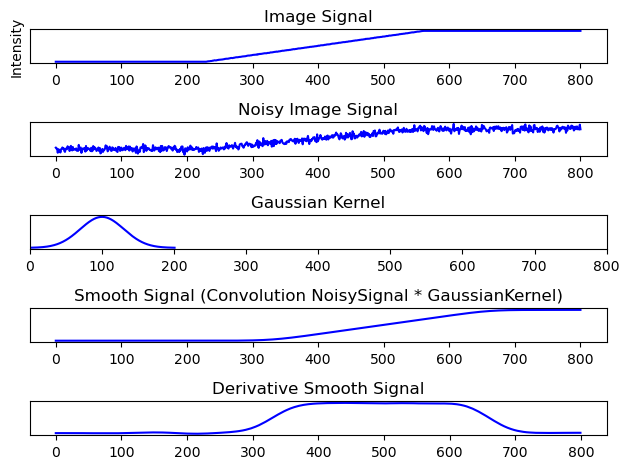

In [16]:
# plotting
fig = plt.figure()

ax = fig.add_subplot(5, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.set_title('Image Signal')
ax.set_ylabel("Intensity")
ax.set_yticks([])
ax.plot(x1,y1, 'b')

ax = fig.add_subplot(5, 1, 2)
ax.set_title('Noisy Image Signal')
ax.set_yticks([])
ax.xaxis.set_ticks_position('bottom')
ax.plot(x2,y2, 'b')

ax = fig.add_subplot(5, 1, 3)
ax.set_title('Gaussian Kernel')
ax.set_yticks([])
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim([0, 800])
ax.plot(x3,y3, 'b')

ax = fig.add_subplot(5, 1, 4)
ax.set_title('Smooth Signal (Convolution NoisySignal * GaussianKernel)')
ax.set_yticks([])
ax.xaxis.set_ticks_position('bottom')
ax.plot(x4,y4, 'b')

ax = fig.add_subplot(5, 1, 5)
ax.set_title('Derivative Smooth Signal')
ax.set_yticks([])
ax.xaxis.set_ticks_position('bottom')
ax.plot(x5[:799],y5, 'b')

fig.tight_layout()
plt.show()

The benefits of convoluting the signal with a "low-pass-filter" speak for itself. Deriving the edge from the smoothed out signal is possible now. 

````{admonition} Outlook: Convolution
:class: note, dropdown
We have seen how convolution can be used for signal processing, for example attenuating noise in images. A convolution is an integral that expresses the amount of overlap of one function as it is shifted over another function. 

**Discrete 1D signals (audio)**
Ingredients: a "signal" $x$, a "filter" $h$
  
$$
(x \ast h)[t] = \sum_{\tau = -\infty}^\infty x[t] h[\tau - t] 
$$
  
**Discrete 2D signals (images)**
  
$$
(x \ast h)[\mathbf{u}] = \sum_{\mathbf{v} \in \mathbb{Z}^2} x[\mathbf{v}] h[\mathbf{u} - \mathbf{v}]
$$
  
**Continuous 1D signals (audio)**
Ingredients: a "signal" $x$, a "filter" $h$
  
$$
(x \ast h)(t) = \int_{-\infty}^{\infty} x(\tau) h(t - \tau) d \tau = \int_{-\infty}^{\infty} h(\tau) x(t - \tau) d \tau
$$
  
**Continuous 2D signals (images)**
  
$$
(x \ast h)(\mathbf{u}) = \iint_{\mathbb{R}^2} x(\mathbf{v}) h(\mathbf{u} - \mathbf{v}) d \mathbf{v} =  \iint_{\mathbb{R}^2} h(\mathbf{v}) u(\mathbf{u} - \mathbf{v}) d \mathbf{v}
$$ 
  
```{admonition} Video: But what is a convolution?
:class: seealso, dropdown

This video by 3Blue1Brown is a worthwhile watch to catch up on or understand how convolution works (23min):
  
<iframe width="560" height="315" src="https://www.youtube.com/embed/KuXjwB4LzSA" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>
```

In regards to the edge detection we have done earlier, We can take a first difference from before:

$$
\verb|img_dx = np.diff(img_bw, axis=0, prepend=0)|
$$

This can be written as a filter, a convolution!

Let

$$
h_v = 
\begin{bmatrix}
1 & 0 \\ -1 & 0
\end{bmatrix}
$$

Then for an image $x$ we have

$$
\begin{align}
    (x \ast h)[u_1, u_2] 
    &= \sum_{v_1 = -\infty}^\infty \sum_{v_2 = -\infty}^\infty h[v_1, v_2] x[u_1 - v_1, u_2 - v_2]\\
    &= \sum_{v_1 = 0}^1 \sum_{v_2 = 0}^0 h[v_1, v_2] x[u_1 - v_1, u_2 - v_2] \\
    &= 1 \cdot x[u_1 - 0, u_2 - 0] + (-1) \cdot  x[u_1 - 1, u_2 - 0] \\
    &= x[u_1, u_2] - x[u_1 - 1, u_2]
\end{align}
$$

Similarly we obtain

$$
\begin{align}
    (x \ast h_h)[u_1, u_2] = x[u_1, u_2] - x[u_1, u_2 - 1]
\end{align}
$$
````

````{admonition} Question: So what is a filter?
:class: hint, dropdown
A filter removes certain aspects of a signal. We have seen in our example how a kernel can remove noise for example. 

For us, in this lecture, it is a linear, shift-invariant system. More precisely, a shift-equivariant system.

$$
\mathcal{H} (x[\cdot - \mathbf{u}]) = (\mathcal{H} x)[\cdot - \mathbf{u}]
$$

Meaning the filtered shifted input equals to the shift filtered input.
````
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## Another example: Unsharp Masking
Unsharp masking is a technique used to sharpen an image with a blurred version of the original. We have seen in the previous example how we can blur an image with a gaussian filter and detect the edges by deriving the blurred signal. The following example only uses two gaussian filters with different sigmas in order to get a similar result as in the first example by subtracting one filtered image from the other. This difference then can be added to the original image, making it sharper. 
<!-- Racoon -->

In [17]:
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

original = scipy.misc.face(gray=True).astype(float)
blurred_original = ndimage.gaussian_filter(original, 3)

filter_blurred_original = ndimage.gaussian_filter(blurred_original, 1)

edges = 30 * (blurred_original - filter_blurred_original)
sharpened = blurred_original + edges

# on the plot visible is
# top: original and sharpened
# bottom: filter_blurred_f and edges

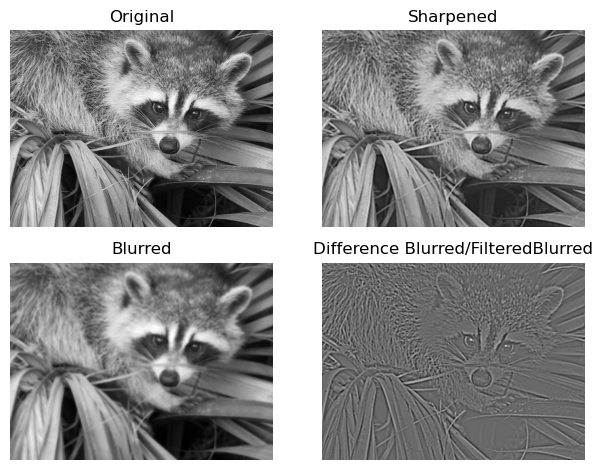

In [18]:
# plotting
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(original, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
plt.imshow(sharpened, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Sharpened')

plt.subplot(2, 2, 3)
plt.imshow(blurred_original, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Blurred')

plt.subplot(2, 2, 4)
plt.imshow(edges, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Difference Blurred/FilteredBlurred')

plt.tight_layout()
plt.show()

Why does this work? It has to do with the difference of gaussian being very similar to the so called laplacian of gaussian filter, which we will look at next.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## Laplacian of Gaussian Filter and Difference of Gaussian
We have seen at the beginning that

$$
\nabla I(x) = \bigl( \frac{\partial I}{\partial x} , \frac{\partial I}{\partial y}  \bigr)(x)
$$

Now, differentiation is, as we've seen as well, a linear operation. So it does commute with other linear filtering operations. More specifically, we can take our convoluted, blurry image $I_\sigma(x) = G_\sigma(x) \ast I(x)$ and write its gradient as

$$
I_\sigma(x) = \nabla \bigl( G_\sigma(x) \ast I(x) \bigr) = \bigl( \nabla G_\sigma(x)\bigr) \ast I(x),
$$

meaning we can derive just the gaussian kernel function and get the same result.

$$
\nabla G_\sigma(x) = \bigl( \frac{\partial G_\sigma}{\partial x} , \frac{\partial G_\sigma}{\partial y}  \bigr) (x) = [-x -y]\frac{1}{\sigma^2} exp(-\frac{x^2 + y^2}{2\sigma^2} )
$$

Further, we not necessarily would want just the blurred image, but the edges itself. This can be achieved by looking for maxima in the edge strength in a direction perpendicular to the edge orientation, meaning along the gradient direction. This directional derivative can then be written as

$$
\nabla I_\sigma(x) = \bigl( \nabla^2 G_\sigma(x)\bigr) \ast I(x)
$$

with 

$$
\nabla^2 G_\sigma(x) = \bigl( \frac{x^2 + y^2}{\sigma^4} - \frac{2}{\sigma^2} \bigr) G_\sigma(x)
$$

The LoG can be approximated quite well with a difference of Gaussian (DoG) computation because their kernel shapes are quite similar, which is exactly what we have done in the previous example.

{cite}`CVAA`
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## Convolution in Audio Processing
We can also apply convolution to 1D signals like audio for example. Given an audio file we can convolve it with a so called impulse response (IR). This impulse responses function like kernels in image proceessing, in that they function as filters and change the original signal. More specifically, by convolving audio and IR, frequencies that are shared between the two sources will be accentuated, while frequencies that are not shared will be attenuated. In music production for example, IRs are used to to add reverb to a dry signal (dry = no reverb) by convolving the impulse response of a specific location with the dry source. An impulse response of a location is nothing but the response of the room/location to a short impulse. There are a lot of complicated and more optimized ways to encapture the reverb of various locations, but the easiest method is to just press the record button and clap. Given a silent environment without noise one would have recorded an impulse response. The next audio snippets include such an impulse response.
#### Original Audio

In [19]:
from scipy.io import wavfile
from IPython.lib.display import Audio

fs2, x = wavfile.read('audio/noreverb-stereo3.wav')
Audio(x, rate=fs2, autoplay=False)

#### Impulse Response

In [20]:
# Reference IR library: http://www.echothief.com/downloads/
fs, h_ir = wavfile.read('audio/TunnelToHeaven3.wav')
Audio(h_ir, rate=fs2, autoplay=False)

```{admonition} Hint: Make your own IR
:class: note

You can easily make your own impulse response of a room with great reverb (or the lecture hall?). Simply record a loud clap and the response and cut it to the start of the clap (or better, the end of the clap transient) and end of reverb. In order for it to work like in the examples you will have to use a .wav file with 22050 Hz as sample rate and the same amount of channels (mono/stereo) as the audio you want to convolve. Or use [this free Online Audio Converter](https://fconvert.com/audio/).
```
#### Convolution Original Audio $\ast$ Impulse Response

In [21]:
from scipy.signal import fftconvolve

x_ir = fftconvolve(x, h_ir)

Audio(x_ir, rate=fs, autoplay=False)
#Audio(x, rate=fs, autoplay=False)

#### Low-Pass Filter
Similarly to how we smoothed out a noisy image, removing high frequency noise, we can use a "one-kernel" as IR and convolve it with the audio in order to get a low-pass filter.

In [22]:
L = int(fs / 1000)

h_lp = np.ones((L, )) / L
x_lp = fftconvolve(x, h_lp, mode='same')
Audio(x_lp, rate=fs, autoplay=False)

#### High-Pass Filter
We can create a qualitatively bad, but for our purposes educational high pass filter with discrete time differences.

In [23]:
Audio(np.diff(np.diff(x)), rate=fs, autoplay=False)

If we recall how for edge detection we have previously plotted one row of an image and concluded, that its derivation won't allow us to detect edges well because of high-frequency noise, we can start to see how this method attenuates low frequencies and accentuates high ones. Maybe even consider the extreme case of the lowest frequency, which wouldn't change with time - a constant. The derivative of a constant is zero, meaning the signal can't pass through. A difference of two values that are the same will obviously be zero. 
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%## Gabor Filter
%BONUS
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%## Canny Edge Detection
%BONUS
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## Convolutional Neural Networks

```{admonition} A very cool demo
:class: note
  
**Check it out [here](https://poloclub.github.io/cnn-explainer/)!**
  
![image.png](images/05-filtering-and-edge-detection/cnn-explainer.png)
```
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## Multiscale Directional Filter Banks

A filter bank is an array of bandpass filters which separates the input signal into multiple components. The recombination of those differently filtered signals then can lead to a better filtering overall. In our case we will introduce a multiscale directional filter bank called the Leung-Malik Filter Bank. Multiscale means that filters of different sizes are used whereas directional refers to the different orientation of the filters. 

### The Leung-Malik Filter Bank

Implementation of the Leung-Malik Filter Bank. {cite}`10.1023/A:1011126920638`

In [24]:
'''
The Leung-Malik (LM) Filter Bank, implementation in python

T. Leung and J. Malik. Representing and recognizing the visual appearance of
materials using three-dimensional textons. International Journal of Computer
Vision, 43(1):29-44, June 2001.

Reference: http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
Python Implementation: https://github.com/tonyjo/LM_filter_bank_python
'''

import numpy as np
import matplotlib.pyplot as plt

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F

F = makeLMfilters()

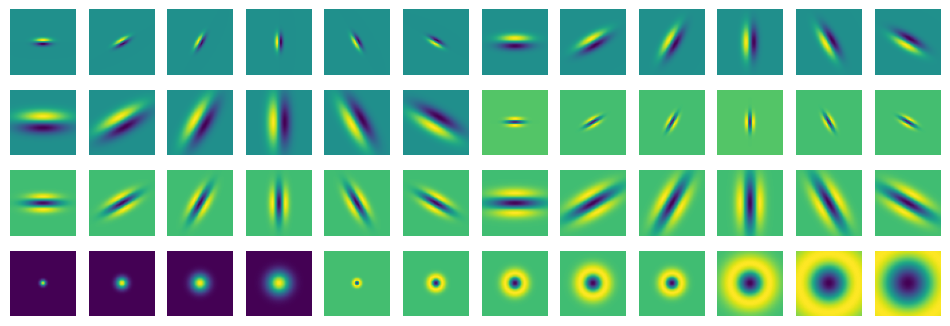

In [25]:
# plotting
fig, axs = plt.subplots(4, 12, figsize=(12, 4))

for i in range(48):
    axs[i//12, i%12].imshow(F[:, :, i])
    axs[i//12, i%12].axis(False)

We can see this filter bank consists of 48 filters in total. The first 3x6 pairs are first order derivatives of Gaussians at 6 orientations and 3 scales, followed by the second order derivatives of Gaussian filters. Furthermore 4 Gaussians and 8 Laplacian of Gaussian filters are part of this bank.

### A last, fun example

In [26]:
import skimage
from scipy.signal import fftconvolve

moon = skimage.data.moon()
moon = moon / moon.max()

crater = moon[60:115, 90:150]
crater /= crater.max()
moonfilt = fftconvolve(moon, crater, mode='same')

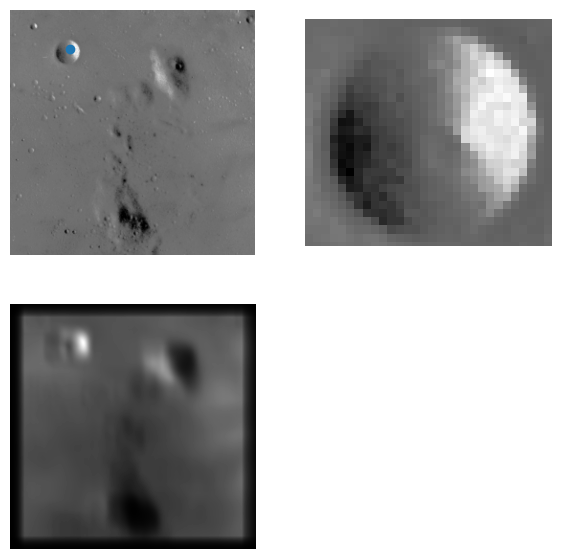

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
[ax.set_axis_off() for ax in axs.ravel()]

axs[0, 0].imshow(moon, cmap='gray')
axs[0, 1].imshow(crater, cmap='gray')
axs[1, 0].imshow(moonfilt**5, cmap='gray')
x_max, y_max = np.unravel_index(moonfilt.argmax(), moonfilt.shape)
axs[0, 0].scatter(y_max - crater.shape[0]//2, x_max) # todo: figure this out   
plt.show()

---

```{bibliography}
:filter: docname in docnames
```


<!-- 
[^1]: This is even true for infinite-support discrete time/space signals. Since they are indexed by integers $\mathbb{Z}$ or pairs of integers $\mathbb{Z}^2$, they are countable, and thus spanned by bases with much fewer elements than the interval $[-\pi, \pi)$ which has as many elements as the real line. -->